# A4 Problems

Because of the exploratory and involved nature of this assignment, I'll sort of be touching on everything as we go along this solution. So instead of labeling each part explicitely, it's wrapped up in the whole document. Sorry if that makes it hard to check one specific thing!

### All Parts

In this assignment, we'll try and find the signal in the data from LIGO for both the Hanford and Livingston detectors. The data may be downloaded [here](https://www.gw-openscience.org/static/events/LOSC_Event_tutorial.zip) which is a zip file containing the data + a tutorial on how to do LIGO data reduction. We'll follow a similar process to the tutorial, but more simplified, and more closely following the concepts learned in class.

Let's first walk ourselves through the process of matched filtering. Thinking of how we've done things usually in class, recall that for a model with a set of parameters $m$, given a noise matrix $N$, the model $A$, and the data $d$, $\chi^2$ minimization gives as the best fit parameter:

$$m = \left(A^T N^{-1} d\right) \left(A^T N^{-1} A \right)^{-1}$$

For matched filtering, we are taking a model $A$ which is our template, and shifting it around to find the best location where it fits the data. For this assignment, the details of how we chose this model are not relevant -- LIGO is constantly searching over many, many templates to find candidate signals -- what matters is that it is given to us, and its single parameter $m$ is how much we shift the template to best fit the data.

Note that we can split our noise matrix up into two components of $N^{-1/2}$. This is for the purposes of ["pre-whitening"](http://hosting.astro.cornell.edu/~cordes/A6523/Prewhitening.pdf) our data. Pre-whitening means to process a set of data before you proceed with some other kind of data analysis in order that the noise of the data behaves more like [white noise](https://en.wikipedia.org/wiki/Colors_of_noise). This does two equivalent things:

1. The power spectrum (remember, spectrum means we're dealing with frequencies, so the amount of signal in each frequency bin) of the data becomes flat
2. The auto-correlation function of the time series becomes more like a delta function (since the noise is now uncorrelated with itself, so you only get a peak in the autocorellation when your function exactly lines up with itself)

The second factor is important because it also implies that when we convolve our template with our data, the resulting output will more resemble a delta function, providing a more convincing detection.

So let's prove to ourselves splitting up our matrix into components of $N^{-1/2}$ whitens the data. If we take our $m$ from before and make this split:

$$m = \left(A^T N^{-1/2}\right) \mathbb{1} \left( N^{-1/2} d \right) \left(\left( A^T N^{-1/2} \right) \mathbb{1} \left( N^{-1/2} A\right)\right)^{-1}$$

So now let's make this look like what we originally had above, but in a new basis where the identity matrix ($\mathbb{1}$) is in place of the noise matrix. Recall the matrix rule $AB^T = (BA^T)^T$, as well as $N^T = N$ by the way the noise matrix is defined:

$$m = \left(N^{-1/2} A\right)^T \mathbb{1} \left( N^{-1/2} d \right) \left(\left( N^{-1/2} A\right)^T \mathbb{1} \left( N^{-1/2} A\right)\right)^{-1}$$

So, this looks just like the $m$ we had originally, but shifted into a basis where $A \rightarrow N^{-1/2} A$ and $N \rightarrow \mathbb{1}$! Thus our pre-whitened template and data are $N^{-1/2} A$ and $N^{-1/2} d$ respectively, which gives a white noise matrix $\mathbb{1}$. 

First we need to come up with a noise model for Hanford and Livingston. To do this, we'll take the strain data, take its power spectrum, and use it as a rough estimate of the noise matrix (we'll assume there's no correlations in the noise matrix and that thus the noise matrix is diagonal, and can be represented as a 1D array). This should be fine since there's very little signal in the LIGO templates compared to the overall strain.

In [1]:
import numpy as np
import scipy.signal.windows as wind
import matplotlib.pyplot as plt
from matplotlib import rcParams

# From Prof. Siever's code
from simple_read_ligo import read_template, read_file

First let's load in the template for the event we want to use, as well as the Hanford and Livingston data. I've made the notebook so that you can comment in which event you want to use.

In [2]:
fns = ['./ligo_data/H-H1_LOSC_4_V2-1126259446-32.hdf5',
       './ligo_data/L-L1_LOSC_4_V2-1126259446-32.hdf5',
       './ligo_data/GW150914_4_template.hdf5']

# fns = ['./ligo_data/H-H1_LOSC_4_V2-1135136334-32.hdf5',
#       './ligo_data/L-L1_LOSC_4_V2-1135136334-32.hdf5',
#       './ligo_data/GW151226_4_template.hdf5']

# fns = ['./ligo_data/H-H1_LOSC_4_V1-1167559920-32.hdf5',
#       './ligo_data/L-L1_LOSC_4_V1-1167559920-32.hdf5',
#       './ligo_data/GW170104_4_template.hdf5']

In [3]:
# _h = hanford, _l = livingston
strain_h, dt_h, utc_h = read_file(fns[0])
strain_l, dt_l, utc_l = read_file(fns[1])
template_h, template_l = read_template(fns[2])

Alright, so we've read in the `strain` for Hanford and Livingston (the strain is just the name for the extending and contracting of spacetime, and is the primary data output from LIGO), as well as the distance between time samples in seconds `dt` and the UTC time of the event `utc`. To make life a slight bit simpler, I'm going to check and make sure the length between time samples `dt` (which is in seconds) for Hanford and Livingston is the same, and just use one variable for both. I'll also make a variable for the number of samples, as well as the sampling rate.

In [4]:
if dt_h == dt_l:
    dt = dt_h

if len(strain_h) == len(strain_l):
    n = len(strain_h)
    
sampling_rate = 1.0/dt

Now we'll take the power spectrum for both the Hanford and Livingston data. Recall that when we use `np.fft`, we're taking the fast Fourier transform, which is an $O(N \log N)$ operation, and computes the Discrete Fourier Transform:

$$X_k = \sum_{n = 0}^{N-1} x_n e^{-i2\pi k n / N} \qquad k = 0, 1, ..., N-1$$

where $X_k$ is the frequency component for wave number $k$. To understand exactly what frequency corresponds to $X_k$, note that $\omega_k = 2\pi k / T$ where $T = n dt$ is the time span of our data. With this notation, we can represent the frequency spectrum for frequencies $\omega_k$ and data $x_n$ occuring at time $t_n$ as:

$$X_k = \sum_{n = 0}^{N-1} x_n e^{-i\omega_k t_n} \qquad k = 0, 1, ..., N-1$$

The power spectrum of a signal is defined as 

$$ S_k = \left| X_k \right|^2 $$

and describes the spectral energy density -- that is, the contribution to the total signal for each frequency bin. Our motivation for looking at the power spectrum is to see for which frequencies the data and template hold most of their signal. This way, we can chop off the frequencies in our data which don't contribute much to us finding our signal. The power spectrum is also an estimate for our [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) (AKA Noise matrix), *in the Fourier domain*, as:

$$cov(X) = E(X X^H)$$

where $H$ represents the complex conjugate transpose and $X$ is a diagonal matrix containing elements $X_k$ on the diagonal. Since our matrix here is diagonal assuming no covariance in the data, then:

$$cov(X) = N = \left| X \right|^2 = S $$

Let's make power spectra for our data and template to see what we're working with in terms of frequency spectrum (note: I use `np.fft.rfft`, which is faster than `np.fft.fft` for purely real data. You also only get `N/2` points back, as the negative frequencies are combined to the positive ones).

In [5]:
# Hanford DFT + Power spectrum (_ft = fourier transform, _ps = power spectrum)
strain_h_ft = np.fft.rfft(strain_h)
ps_h = np.abs(strain_h_ft**2)
# Livingston DFT + Power spectrum
strain_l_ft = np.fft.rfft(strain_l)
ps_l = np.abs(strain_l_ft**2)
# Templates DFT + Power spectrum
template_h_ft = np.fft.rfft(template_h)
ps_template_h = np.abs(template_h_ft)**2
template_l_ft = np.fft.rfft(template_l)
ps_template_l = np.abs(template_l_ft)**2

We'll also calculate what frequencies each power spectrum bin corresponds to. Given `dt` is in seconds, this will give us frequencies in Hz.

In [6]:
freqs = np.fft.rfftfreq(n, d=dt)

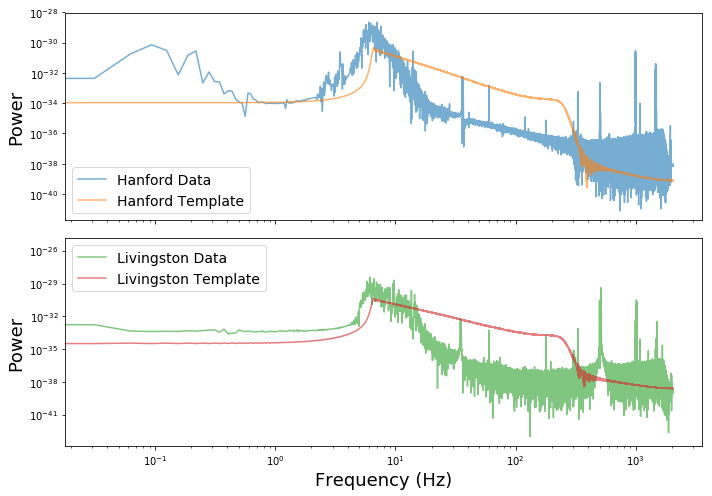

In [7]:
# My preferred plotting parameters
rcParams['figure.figsize'] = (10,7)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].loglog(freqs, ps_h, alpha=0.6, label="Hanford Data")
ax[0].loglog(freqs, ps_template_h, alpha=0.6, label="Hanford Template")
ax[1].loglog(freqs, ps_l, alpha=0.6, label="Livingston Data", color="C2")
ax[1].loglog(freqs, ps_template_l, alpha=0.6, label="Livingston Template", color="C3")
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[0].set_ylabel("Power", fontsize=18)
ax[1].set_ylabel("Power", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout()
plt.show()

Alright, so there's a region from 10 ~ 300 Hz where the template has significantly more power than the Hanford and Livingston data. This is still before we've done any cleaning, so let's just keep this in mind and revisit this plot later.

To get started with the cleaning, we'll take a window function. The importance of a window function is that it helps us avoid [ringing](https://en.wikipedia.org/wiki/Ringing_artifacts) in our Fourier transform, which is essentially just discontinuous noise artifacts due to the fact our data is over a finite time interval and the beginning/end point are discontinuous. Most windows taper the data to zero at the edges so that the function is then periodic, reducing ringing and power in sidelobes. What might a good choice of window be? Referencing the windows on [the wikipedia page](https://en.wikipedia.org/wiki/Window_function), I will use the Nuttal window as its fourier transform has low power in the sidelobes. The tradeoff is that the FWHM of the main lobe is wider, so I lose frequency resolution, but the frequency resolution of LIGO is already enough that this shouldn't impact our ability to find the signal.

In [8]:
# Get the window from scipy.signal.windows
window = wind.nuttall(len(strain_h))

# Make the windowed Hanford/Livingston data + the templates (_w = windowed)
strain_h_ft_w = np.fft.rfft(window*strain_h)
ps_h_w = abs(strain_h_ft_w)**2
strain_l_ft_w = np.fft.rfft(window*strain_l)
ps_l_w = abs(strain_l_ft_w)**2
template_h_ft_w = np.fft.rfft(window*template_h)
ps_template_h_w = np.abs(template_h_ft_w)**2
template_l_ft_w = np.fft.rfft(window*template_l)
ps_template_l_w = np.abs(template_l_ft_w)**2

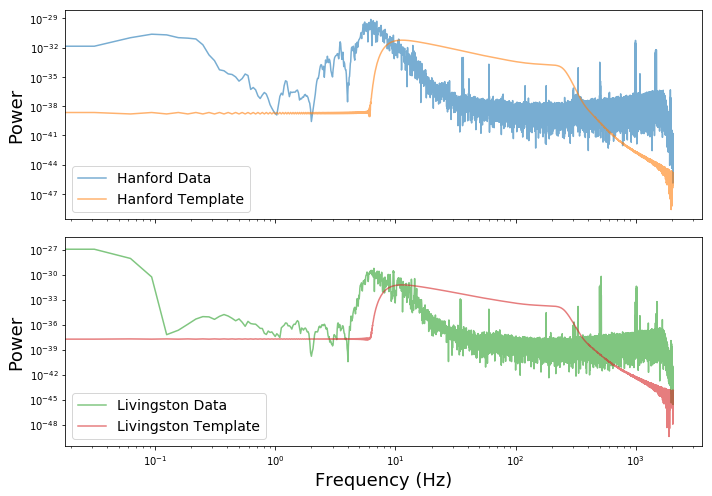

In [9]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].loglog(freqs, ps_h_w, alpha=0.6, label="Hanford Data")
ax[0].loglog(freqs, ps_template_h_w, alpha=0.6, label="Hanford Template")
ax[1].loglog(freqs, ps_l_w, alpha=0.6, label="Livingston Data", color="C2")
ax[1].loglog(freqs, ps_template_l_w, alpha=0.6, label="Livingston Template", color="C3")
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[0].set_ylabel("Power", fontsize=18)
ax[1].set_ylabel("Power", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout()
plt.show()

Nice, looks like the whitening has created a more well defined region where the templates have more power than the data (which is essentially our noise). However, for the Livingston data, some noise got leaked to the low frequencies. This is fine, as our next step is cleaning up the frequency information. We want to preserve the frequency in a region where the noise is more "white" than "pink" or "red" (refer to the white noise article linked above), e.g. the noise is ~constant per frequency. Luckily that region corresponds well to the region where the power in the template is greater than the power in the data. Let's plot this in linear frequency space so we can tell where the chop frequencies more easily. Looking in log space, we can probably chop everything left of around 15 Hz, and anything right of around 1700 Hz:

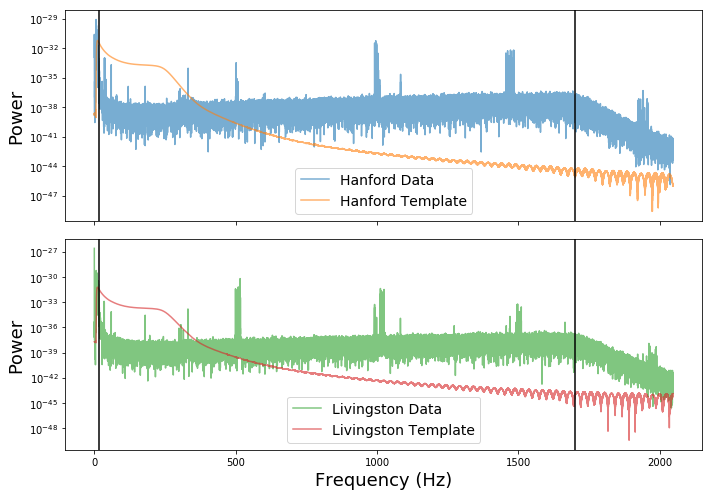

In [10]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].semilogy(freqs, ps_h_w, alpha=0.6, label="Hanford Data")
ax[0].semilogy(freqs, ps_template_h_w, alpha=0.6, label="Hanford Template")
ax[1].semilogy(freqs, ps_l_w, alpha=0.6, label="Livingston Data", color="C2")
ax[1].semilogy(freqs, ps_template_l_w, alpha=0.6, label="Livingston Template", color="C3")
ax[0].axvline(15, color='k')
ax[0].axvline(1700, color='k')
ax[1].axvline(15, color='k')
ax[1].axvline(1700, color='k')
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[0].set_ylabel("Power", fontsize=18)
ax[1].set_ylabel("Power", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout()
plt.show()

Alright, it looks like the frequencies in our range are nice and constant in frequency (more "white noise-like"). Note I did some playing around not shown in this notebook to find the exact Hz ranges I preferred for the cutoffs. So I'll make the cuts and then plot again in log-log space:

In [11]:
ind_low = np.argmin(abs(freqs - 15))
ind_high = np.argmin(abs(freqs - 1700))

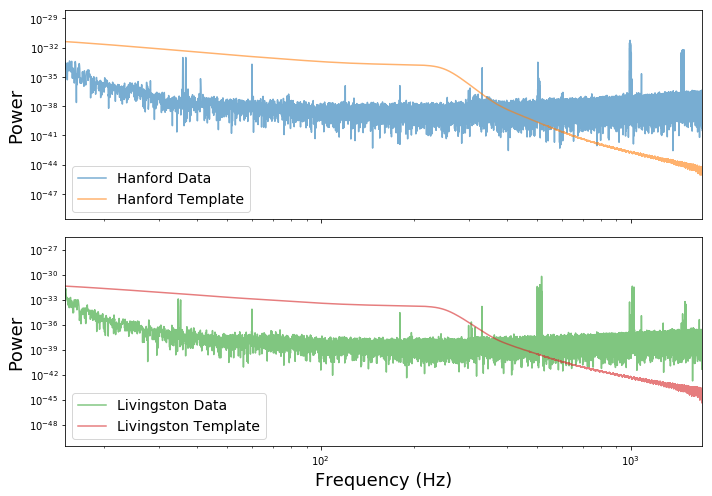

In [12]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].loglog(freqs, ps_h_w, alpha=0.6, label="Hanford Data")
ax[0].loglog(freqs, ps_template_h_w, alpha=0.6, label="Hanford Template")
ax[1].loglog(freqs, ps_l_w, alpha=0.6, label="Livingston Data", color="C2")
ax[1].loglog(freqs, ps_template_l_w, alpha=0.6, label="Livingston Template", color="C3")
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[0].set_ylabel("Power", fontsize=18)
ax[1].set_ylabel("Power", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[0].set_xlim(left=freqs[ind_low], right = freqs[ind_high])
plt.tight_layout()
plt.show()

The final step in cleaning up our noise model is to smooth it so that the features are less spiky -- we want to "reduce the noise in our noise", so to speak. In the LIGO notebook, they do this by fitting a curve to the relevant frequency region. But I'm going to smooth with a Gaussian filter (convolve a gaussian with unit area over the data).

In [13]:
from scipy.ndimage import gaussian_filter

In [14]:
# Smooth with a Gaussian kernel of width 50 times bins
# Chose this number of time bins pretty arbitrarily.
ps_h_w_smooth = gaussian_filter(ps_h_w, sigma=50)
ps_l_w_smooth = gaussian_filter(ps_l_w, sigma=50)

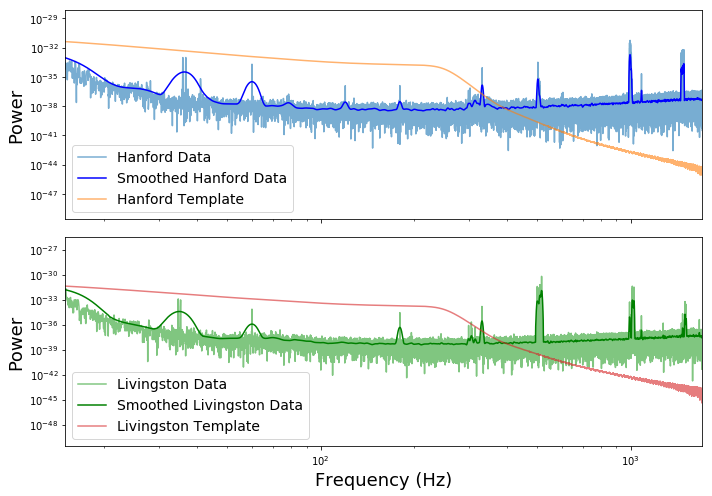

In [15]:
# Same plot as always but with smoothed data
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].loglog(freqs, ps_h_w, alpha=0.6, label="Hanford Data")
ax[0].loglog(freqs, ps_h_w_smooth, alpha=1, color='b', label="Smoothed Hanford Data")
ax[0].loglog(freqs, ps_template_h_w, alpha=0.6, label="Hanford Template")
ax[1].loglog(freqs, ps_l_w, alpha=0.6, label="Livingston Data", color="C2")
ax[1].loglog(freqs, ps_l_w_smooth, alpha=1, color='g', label="Smoothed Livingston Data")
ax[1].loglog(freqs, ps_template_l_w, alpha=0.6, label="Livingston Template", color="C3")
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[0].set_ylabel("Power", fontsize=18)
ax[1].set_ylabel("Power", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[0].set_xlim(left=freqs[ind_low], right = freqs[ind_high])
plt.tight_layout()
plt.show()

Alright! That looks way way better after smoothing. The smoothed data is much less messy, and will make a much better noise matrix estimation. Now I'll relable this windows, Fourier transformed, bad-frequency-axed, smoothed power spectrum as the **noise matrix.** We'll also divide and take the square root for convenience when pre-whitening with it.

In [16]:
# N is our noise model
N_h = ps_h_w_smooth
N_l = ps_l_w_smooth
# For convenience
N_h_inv_sqrt = 1/np.sqrt(N_h)
N_l_inv_sqrt = 1/np.sqrt(N_l)

In [17]:
# We want to not consider certain frequency bins that don't have well characterized
# noise, so set the noise to those to infinity (eg: inverse = 0)
for array in [N_h_inv_sqrt, N_l_inv_sqrt]:
    array[:ind_low] = 0
    array[ind_high:] = 0

Now that we have our noise matrix, we can pre-whiten our data! Recall this means using $N^{-1/2} A$ and $N^{-1/2} d$ for the template and strain respectively when doing the matched filter.

In [18]:
strain_h_ft_whitened = N_h_inv_sqrt*strain_h_ft_w
strain_h_whitened = np.fft.irfft(strain_h_ft_whitened, n)
strain_l_ft_whitened = strain_l_ft_w*N_l_inv_sqrt
strain_l_whitened = np.fft.irfft(strain_l_ft_whitened, n)
template_h_ft_whitened = template_h_ft_w*N_h_inv_sqrt
template_h_whitened = np.fft.irfft(template_h_ft_whitened, n)
template_l_ft_whitened = template_l_ft_w*N_l_inv_sqrt
template_l_whitened = np.fft.irfft(template_l_ft_whitened, n)

Now we'll matched filter the whitened data with the whitened template. Recall this is taking the convolution of the template with the data. Convolution in the regular space is the same thing as multiplication in the Fourier domain, so we'll multiply in the Fourier domain and then inverse fourier transform to get the results of our matched filters!

In [19]:
mf_ft_h = strain_h_ft_whitened * np.conj(template_h_ft_whitened)
mf_h = np.fft.irfft(mf_ft_h, n)
mf_ft_l = strain_l_ft_whitened * np.conj(template_l_ft_whitened)
mf_l = np.fft.irfft(mf_ft_l, n)

Let's also make a time array so we can figure out when from the start of the timestream the event was detected

In [20]:
time = np.arange(0, n)*dt

We'll make a plot of our matched filter output before converting to SNR.

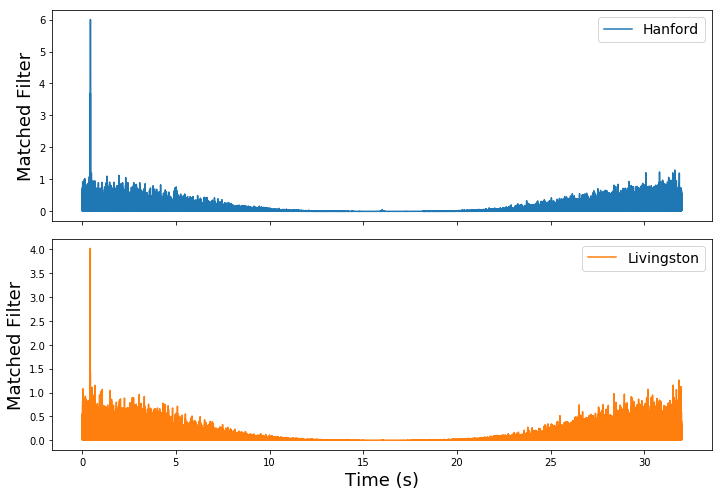

In [21]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(time, abs(mf_h),label='Hanford')
ax[1].plot(time, abs(mf_l),label='Livingston', c="C1")
ax[1].set_xlabel("Time (s)", fontsize=18)
ax[0].set_ylabel("Matched Filter", fontsize=18)
ax[1].set_ylabel("Matched Filter", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout()
plt.show()

Now we need to convert this matched filter output to SNR. To do this, we need to divide our matched filter output $m$ with some $\sigma_m$ to get an SNR. To estimate $\sigma_m$, we'll use the square root of the covariance matrix. Remember, the noise model we had earlier was for the data, so that's not the covariance matrix we care about now -- we want to know this matrix for the parameter $m$, our matched filter output. We'll estimate the covariance matrix with the expectation: $< m m^T >$. Thus, if the covariance matrix gives $\sigma_m^2$, we can estimate:
$$\sigma_m = \sqrt{< m m^T>}$$

Let's calculate $m m^T$. Using our representation of $m$ from before, but not in the whitened basis:
$$\left< m m^T \right> = \left< \left( A^T N^{-1} A\right)^{-1} A N^{-1} d \cdot d^T N^{-1} A^T \left(A^T N^{-1} A \right)^{-1}\right>$$

Now, using our argument that $d$, the strain, is mostly just noise, we'll argue $d d^T \approx N$. Thus:
$$\left< m m^T \right> = \left< \left( A^T N^{-1} A\right)^{-1} A \left[N^{-1} N\right] N^{-1} A^T \left(A^T N^{-1} A \right)^{-1}\right>$$
$$\left< m m^T \right> = \left< \left[ \left( A^T N^{-1} A\right)^{-1} A N^{-1} A^T \right] \left(A^T N^{-1} A \right)^{-1}\right>$$
$$\left< m m^T \right> = \left< \left(A^T N^{-1} A \right)^{-1}\right>$$

Thus to calculate our $\sigma_m$: 

$$\sigma_m = \left< m m^T \right> = \sqrt{\left< \left(A^T N^{-1} A \right)^{-1}\right>}$$

And our SNR is:

$$SNR = m/\sigma_m$$

Taking this all in mind, we'll form the $\sigma_m$ from our whitened template ($N^{-1/2} A$), since all the arrays in this problem are 1D and thus squaring that gives the same thing as inside the expectation.

In [22]:
sigma_h = np.sqrt(np.mean(template_h_whitened**2))
sigma_l = np.sqrt(np.mean(template_l_whitened**2))
SNR_h = mf_h/sigma_h
SNR_l = mf_l/sigma_l

In [23]:
print("Noise estimate for Hanford: %.2e" % (sigma_h))
print("Noise estimate for Livingston: %.2e" % (sigma_l))

Noise estimate for Hanford: 1.94e-01
Noise estimate for Livingston: 1.78e-01


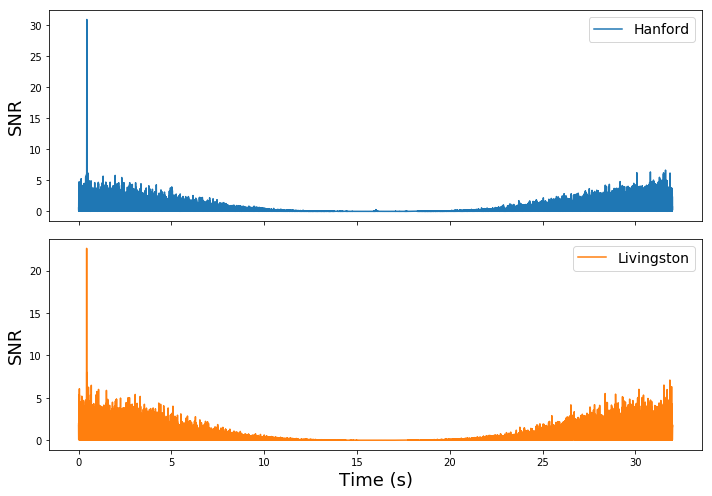

In [24]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(time, abs(SNR_h),label='Hanford')
ax[1].plot(time, abs(SNR_l),label='Livingston',c="C1")
ax[1].set_xlabel("Time (s)", fontsize=18)
ax[0].set_ylabel("SNR", fontsize=18)
ax[1].set_ylabel("SNR", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout()
plt.show()

In [25]:
print("Hanford matched filter SNR: %.2f" % (abs(SNR_h).max()))
print("Livingston matched filter SNR: %.2f" % (abs(SNR_l).max()))

Hanford matched filter SNR: 30.86
Livingston matched filter SNR: 22.64


Now we'll compare this to the RMS in the scatter around the matched filter best location. We'll choose to take the region fairly close to the peak, as this region is less contaminated by the shape of the window function.

In [26]:
rms_h = np.std(mf_h[np.argmax(mf_h)+100:np.argmax(mf_h)+1100])
rms_l = np.std(mf_l[np.argmax(mf_l)+100:np.argmax(mf_l)+1100])

SNR_h_2 = abs(mf_h)/rms_h
SNR_l_2 = abs(mf_l)/rms_l

In [27]:
print("Noise estimate for Hanford based on scatter: %.2e" % (rms_h))
print("Noise estimate for Livingston based on scatter: %.2e" % (rms_l))

Noise estimate for Hanford based on scatter: 3.53e-01
Noise estimate for Livingston based on scatter: 3.56e-01


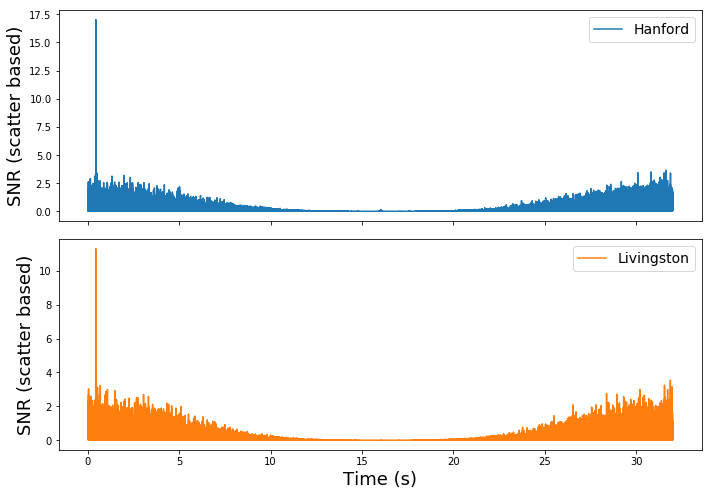

In [28]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(time, abs(SNR_h_2),label='Hanford')
ax[1].plot(time, abs(SNR_l_2),label='Livingston',c="C1")
ax[1].set_xlabel("Time (s)", fontsize=18)
ax[0].set_ylabel("SNR (scatter based)", fontsize=18)
ax[1].set_ylabel("SNR (scatter based)", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout()
plt.show()

In [29]:
print("Hanford matched filter SNR based on scatter: %.2f" % (abs(SNR_h_2).max()))
print("Livingston matched filter SNR based on scatter: %.2f" % (abs(SNR_l_2).max()))

Hanford matched filter SNR based on scatter: 17.01
Livingston matched filter SNR based on scatter: 11.31


Alright, the results are fairly similar, though the SNR we get by scatter is lower than we get using the analytic formula. The disagreement may come from the approximations used when constructing our noise model (eg: $N$ is equal to the smoothed, bad-frequencies removed power spectrum of the data).

Now let's find the "half-power frequency": the frequency at which half the power of the signal comes from above, and half comes from below. To do this, we'll take our pre-whitened template (which contains information about the power in the signal), and make a cumulative sum array. We'll find the index at which this cumulative sum array reaches half the maximum values, and then use this index to find the corresponding frequency value.

In [30]:
# Power spectra of whitened templates
template_h_ps = abs(template_h_ft_whitened)**2
template_l_ps = abs(template_l_ft_whitened)**2

# Make the cumulative sum arrays
cumsum_h = np.cumsum(template_h_ps)
cumsum_l = np.cumsum(template_l_ps)

# Find the index closest to half the total sum
ind_freq_h = np.argmin(abs(cumsum_h - template_h_ps.sum()/2.))
ind_freq_l = np.argmin(abs(cumsum_l - template_l_ps.sum()/2.))

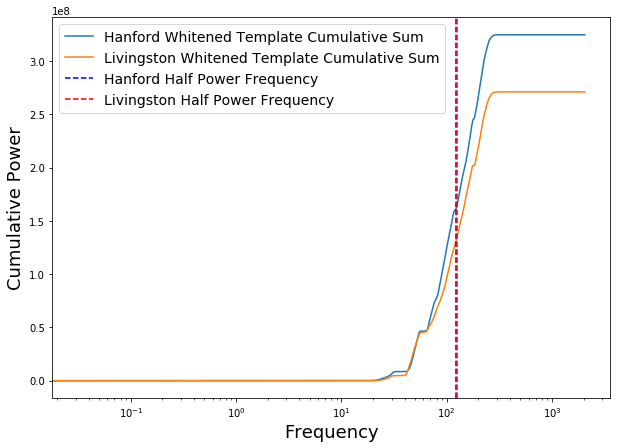

In [31]:
plt.semilogx(freqs,cumsum_h,label='Hanford Whitened Template Cumulative Sum')
plt.semilogx(freqs,cumsum_l,label='Livingston Whitened Template Cumulative Sum')
plt.axvline(freqs[ind_freq_h],ls='--',label='Hanford Half Power Frequency',c='b')
plt.axvline(freqs[ind_freq_l],ls='--',label='Livingston Half Power Frequency',c='r')
plt.legend(fontsize=14)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Cumulative Power", fontsize=18)
plt.show()

In [32]:
print('Hanford Half Power Frequency: %.2f Hz' % (freqs[ind_freq_h]))
print('Livingston Half Power Frequency: %.2f Hz' % (freqs[ind_freq_l]))

Hanford Half Power Frequency: 123.53 Hz
Livingston Half Power Frequency: 125.50 Hz


Cool, so the half power frequency is ~125 Hz for both Hanford and Livingston detections (at least, for the first of the event filenames). This frequency should represent approximately what the frequency of oscillation of the black hole binary was before merger.

Let's see how well we can localize the time of arrival of the signal by zooming into the peak SNR region

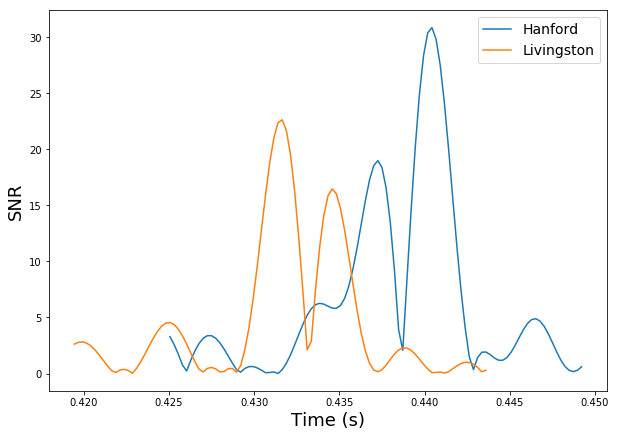

In [33]:
ind_zoom_low_h = np.argmax(SNR_h) - 50
ind_zoom_high_h = np.argmax(SNR_h) + 50
ind_zoom_low_l = np.argmax(SNR_l) - 50
ind_zoom_high_l = np.argmax(SNR_l) + 50
plt.plot(time[ind_zoom_low_h:ind_zoom_high_h], abs(SNR_h)[ind_zoom_low_h:ind_zoom_high_h],label='Hanford')
plt.plot(time[ind_zoom_low_l:ind_zoom_high_l], abs(SNR_l)[ind_zoom_low_l:ind_zoom_high_l],label='Livingston')
plt.xlabel("Time (s)", fontsize=18)
plt.ylabel("SNR",fontsize=18)
plt.legend(fontsize=14)
plt.show()

In [34]:
delta_toa_visual = abs(time[np.argmax(abs(SNR_l))] - time[np.argmax(abs(SNR_h))])
print("Difference in arrival time of GW between Hanford and Livingston: %.2e s" % (delta_toa_visual))

Difference in arrival time of GW between Hanford and Livingston: 8.79e-03 s


Alright, so to properly get an estimate on time of arrival error, I could fit a gaussian to the main peak in each SNR timeseries, and then use the resulting standard deviation as an error estimate. But I'm lazy and just going to visually inspect and say we can localize to within about 0.002 seconds. Now we know the detectors are a few thousand kilometers apart, so how well should we expect to be able to localize the event in time? Each detector individually can localize to within about 0.002 seconds, but between them the localization is ~0.01 seconds apart. If we take the time between detection at each detector as a metric for time of arrival localization, and take the Hanford-Livingston distance as 3000km:

In [35]:
distance = 3000 # in km
c = 300000 # speed of light in km/s
delta_toa = distance/c
print("Calculated difference in arrival time of GW between Hanford and Livingston: %.2e s" % (delta_toa))

Calculated difference in arrival time of GW between Hanford and Livingston: 1.00e-02 s


Bang on, the distance we get from that estimation is exactly what we visually inspect on our matched filter output zoom. So between detectors, events arrive ~0.01 s apart.